In [2]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd
import spectools_ir

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
hitran_data_H2O = extract_hitran_data('H2O',4.6,5.42,eupmax=4000,aupmin=0)

In [4]:
convol_fwhm = 30.
au=1.5e11
#Make slab model
#This can take a few seconds to run.  It is primarily limited by the convolution time.
CO_model=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.45,convol_fwhm=convol_fwhm,d_pc=140.,res=1e-5) # play with convol_fwhm (broader for IQ tau?)
water_model=make_spec('H2O',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.45,convol_fwhm=convol_fwhm,d_pc=140.,res=1e-5) # play with convol_fwhm (broader for IQ tau?)

Reading partition function from:  https://hitran.org/data/Q/q26.txt
Reading partition function from:  https://hitran.org/data/Q/q1.txt


In [5]:
lineflux_data=pickle.load(open('lineflux_data.p','rb'))

## Features around 4.7

In [6]:
#setting the bounds of the feature:
lower_limit = 4.777
upper_limit = 4.8          

#chosing sources:
source_0  = 'AS205'
source_1  = 'CITau'
source_2  = 'FZTau'

#doppler shifts for each source:
doppler_shift_0 = 0
doppler_shift_1 = 0
doppler_shift_2 = 0

(4.777, 4.8)

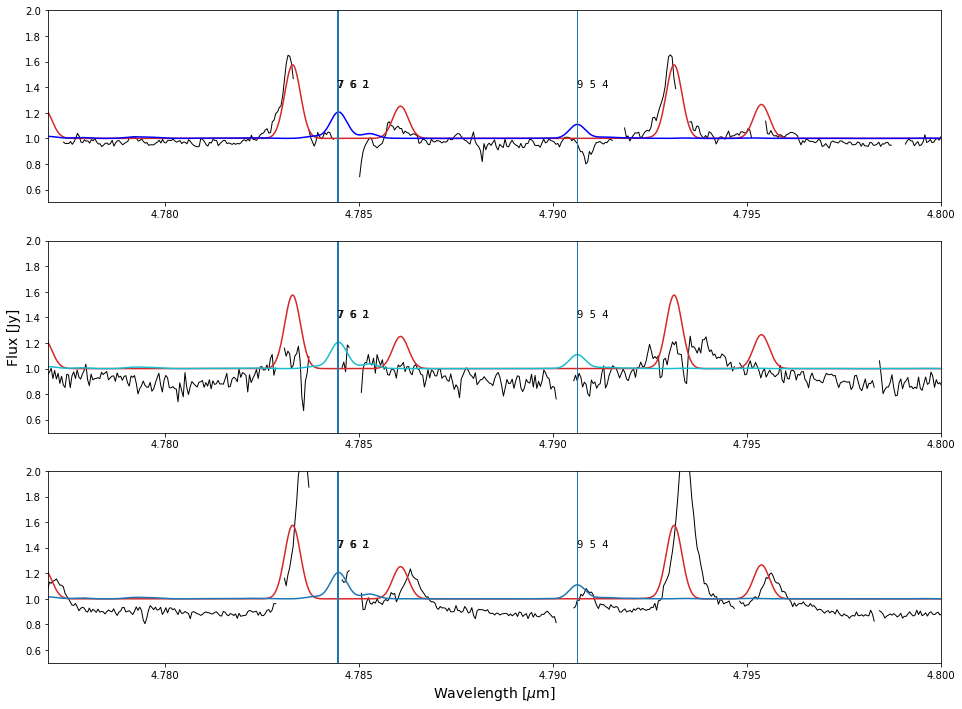

In [7]:
###Plotting Routine###
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize = (16,12))

#pulling the data:
infile_0  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_0+'_orders.fits'
infile_1  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_1+'_orders.fits'
infile_2  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_2+'_orders.fits'
hdulist_0 = fits.open(infile_0) 
hdulist_1 = fits.open(infile_1) 
hdulist_2 = fits.open(infile_2) 
wave_0    = hdulist_0[1].data['wave']
wave_1    = hdulist_1[1].data['wave']
wave_2    = hdulist_2[1].data['wave']
flux_0    = hdulist_0[1].data['flux']
flux_1    = hdulist_1[1].data['flux']
flux_2    = hdulist_2[1].data['flux']

#ploting the data:
axs[0].plot(wave_0+doppler_shift_0, flux_0, linewidth=1, color='k')
axs[1].plot(wave_1+doppler_shift_1, flux_1, linewidth=1, color='k')
axs[2].plot(wave_2+doppler_shift_2, flux_2, linewidth=1, color='k')

#plotting the models, CO and water:
axs[0].plot(CO_model['spectrum']['wave']+doppler_shift_0, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[1].plot(CO_model['spectrum']['wave']+doppler_shift_1, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[2].plot(CO_model['spectrum']['wave']+doppler_shift_2, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[0].plot(water_model['spectrum']['wave']+doppler_shift_0, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='b')
axs[1].plot(water_model['spectrum']['wave']+doppler_shift_1, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='C9')    
axs[2].plot(water_model['spectrum']['wave']+doppler_shift_2, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='C0')

#adding lines for quantum numbers:
for i,lam in enumerate(water_model['lineparams']['wave']):
    if((lam>lower_limit) & (lam<upper_limit) & (water_model['lineparams']['eup_k'][i]>4000) & (water_model['lineparams']['tau_peak'][i]>0.15)):
        axs[0].axvline(lam, linewidth=1, color='tab:blue') 
        axs[1].axvline(lam, linewidth=1, color='tab:blue') 
        axs[2].axvline(lam, linewidth=1, color='tab:blue') 
        axs[0].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        axs[1].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        axs[2].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        
axs[2].set_xlabel('Wavelength [$\mu$m]', fontsize=14)
axs[1].set_ylabel('Flux [Jy]', fontsize=14)
axs[0].tick_params(axis ='both', labelbottom='True')
axs[1].tick_params(axis ='both', labelbottom='True')
axs[0].set_ylim(0.5, 2)
axs[2].set_xlim(lower_limit, upper_limit)


## Features around 4.96 

In [8]:
#setting the bounds of the feature:
lower_limit = 4.96
upper_limit = 4.975       

#chosing sources:
source_0  = 'AS205'
source_1  = 'CITau'
source_2  = 'FZTau'

#doppler shifts for each source:
doppler_shift_0 = 0
doppler_shift_1 = 0
doppler_shift_2 = 0

(4.96, 4.975)

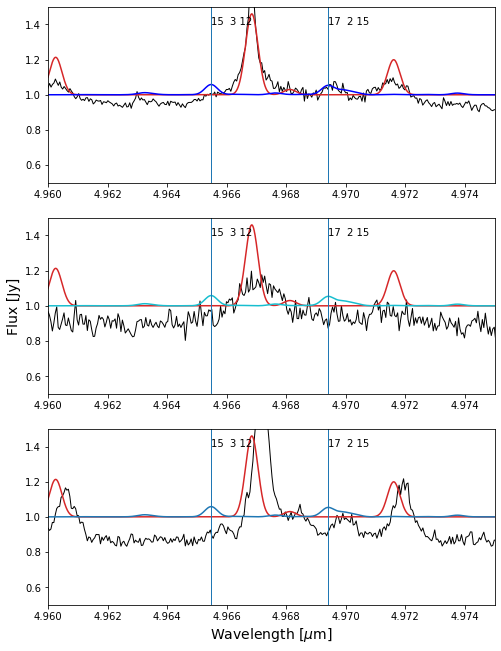

In [9]:
###Plotting Routine###
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize = (8,11))

#pulling the data:
infile_0  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_0+'_orders.fits'
infile_1  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_1+'_orders.fits'
infile_2  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_2+'_orders.fits'
hdulist_0 = fits.open(infile_0) 
hdulist_1 = fits.open(infile_1) 
hdulist_2 = fits.open(infile_2) 
wave_0    = hdulist_0[1].data['wave']
wave_1    = hdulist_1[1].data['wave']
wave_2    = hdulist_2[1].data['wave']
flux_0    = hdulist_0[1].data['flux']
flux_1    = hdulist_1[1].data['flux']
flux_2    = hdulist_2[1].data['flux']

#ploting the data:
axs[0].plot(wave_0+doppler_shift_0, flux_0, linewidth=1, color='k')
axs[1].plot(wave_1+doppler_shift_1, flux_1, linewidth=1, color='k')
axs[2].plot(wave_2+doppler_shift_2, flux_2, linewidth=1, color='k')

#plotting the models, CO and water:
axs[0].plot(CO_model['spectrum']['wave']+doppler_shift_0, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[1].plot(CO_model['spectrum']['wave']+doppler_shift_1, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[2].plot(CO_model['spectrum']['wave']+doppler_shift_2, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[0].plot(water_model['spectrum']['wave']+doppler_shift_0, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='b')
axs[1].plot(water_model['spectrum']['wave']+doppler_shift_1, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='C9')    
axs[2].plot(water_model['spectrum']['wave']+doppler_shift_2, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='C0')

#adding lines for quantum numbers:
for i,lam in enumerate(water_model['lineparams']['wave']):
    if((lam>lower_limit) & (lam<upper_limit) & (water_model['lineparams']['eup_k'][i]>4000) & (water_model['lineparams']['tau_peak'][i]>0.15)):
        axs[0].axvline(lam, linewidth=1, color='tab:blue') 
        axs[1].axvline(lam, linewidth=1, color='tab:blue') 
        axs[2].axvline(lam, linewidth=1, color='tab:blue') 
        axs[0].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        axs[1].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        axs[2].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        
axs[2].set_xlabel('Wavelength [$\mu$m]', fontsize=14)
axs[1].set_ylabel('Flux [Jy]', fontsize=14)
axs[0].tick_params(axis ='both', labelbottom='True')
axs[1].tick_params(axis ='both', labelbottom='True')
axs[0].set_ylim(0.5, 1.5)
axs[2].set_xlim(lower_limit, upper_limit)

## Feature Near 5.1

In [70]:
#setting the bounds of the feature:
lower_limit = 5.1
upper_limit = 5.12        

#chosing sources:
source_0  = 'AS205'
source_1  = 'CITau'
source_2  = 'FZTau'

#doppler shifts for each source:
doppler_shift_0 = 0
doppler_shift_1 = 0
doppler_shift_2 = 0

(5.1, 5.12)

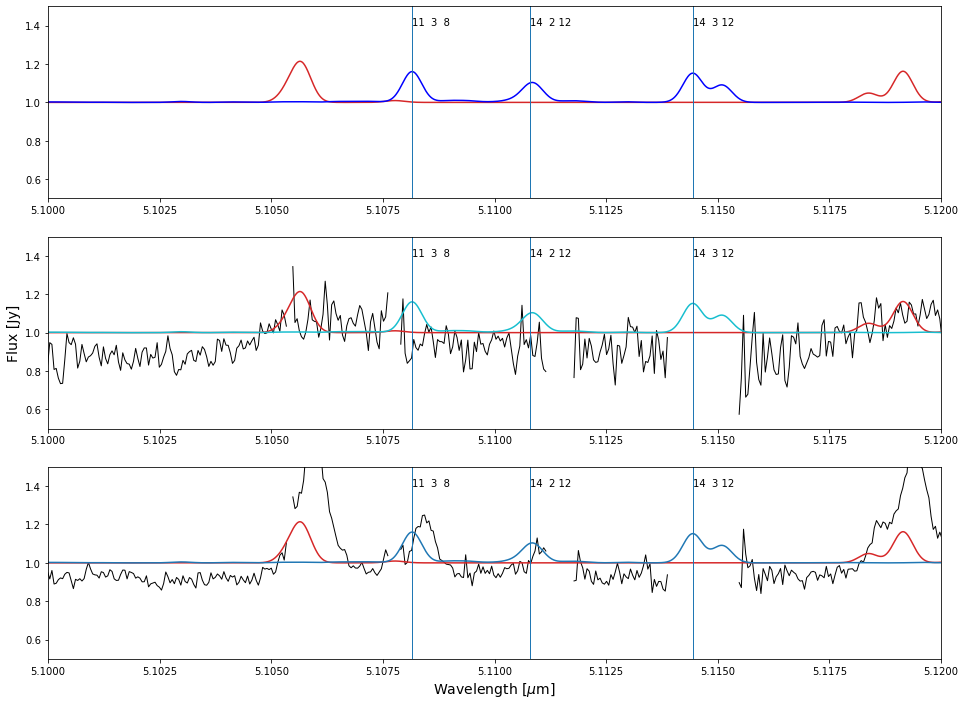

In [71]:
###Plotting Routine###
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize = (16,12))

#pulling the data:
infile_0  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_0+'_orders.fits'
infile_1  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_1+'_orders.fits'
infile_2  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+source_2+'_orders.fits'
hdulist_0 = fits.open(infile_0) 
hdulist_1 = fits.open(infile_1) 
hdulist_2 = fits.open(infile_2) 
wave_0    = hdulist_0[1].data['wave']
wave_1    = hdulist_1[1].data['wave']
wave_2    = hdulist_2[1].data['wave']
flux_0    = hdulist_0[1].data['flux']
flux_1    = hdulist_1[1].data['flux']
flux_2    = hdulist_2[1].data['flux']

#ploting the data:
axs[0].plot(wave_0+doppler_shift_0, flux_0, linewidth=1, color='k')
axs[1].plot(wave_1+doppler_shift_1, flux_1, linewidth=1, color='k')
axs[2].plot(wave_2+doppler_shift_2, flux_2, linewidth=1, color='k')

#plotting the models, CO and water:
axs[0].plot(CO_model['spectrum']['wave']+doppler_shift_0, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[1].plot(CO_model['spectrum']['wave']+doppler_shift_1, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[2].plot(CO_model['spectrum']['wave']+doppler_shift_2, CO_model['spectrum']['convolflux']+1, label='Convolved CO Model Spectrum', color='C3')
axs[0].plot(water_model['spectrum']['wave']+doppler_shift_0, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='b')
axs[1].plot(water_model['spectrum']['wave']+doppler_shift_1, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='C9')    
axs[2].plot(water_model['spectrum']['wave']+doppler_shift_2, water_model['spectrum']['convolflux']+1, label='Convolved H20 Model Spectrum', color='C0')

#adding lines for quantum numbers:
for i,lam in enumerate(water_model['lineparams']['wave']):
    if((lam>lower_limit) & (lam<upper_limit) & (water_model['lineparams']['eup_k'][i]>4000) & (water_model['lineparams']['tau_peak'][i]>0.15)):
        axs[0].axvline(lam, linewidth=1, color='tab:blue') 
        axs[1].axvline(lam, linewidth=1, color='tab:blue') 
        axs[2].axvline(lam, linewidth=1, color='tab:blue') 
        axs[0].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        axs[1].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        axs[2].text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
        
axs[2].set_xlabel('Wavelength [$\mu$m]', fontsize=14)
axs[1].set_ylabel('Flux [Jy]', fontsize=14)
axs[0].tick_params(axis ='both', labelbottom='True')
axs[1].tick_params(axis ='both', labelbottom='True')
axs[0].set_ylim(0.5, 1.5)
axs[2].set_xlim(lower_limit, upper_limit)
